In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
# import bbknn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import seaborn as sns

import scipy.stats as st
import sys, os
import json

In [2]:
with open(r".\ColorMap.csv", "r") as file:
    my_cmap_df = pd.read_csv(file, header=0)
    my_cmap = ListedColormap(my_cmap_df["HEX_Code"].to_list())

# Adding custom font
fonts= [r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Code\Arimo\Arimo-Regular.ttf",
        r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Code\Arimo\Arimo-SemiBold.ttf",
        r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Code\Arimo\Arimo-Italic.ttf",
        r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Code\Arimo\Arimo-SemiBoldItalic.ttf"]

for font in fonts:
    fm.fontManager.addfont(font)

figures_folder = r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Figures\Icons"

sc.set_figure_params(
    dpi=80,
    dpi_save= 600,
    facecolor="white",
    transparent= True,
    color_map= "RdPu")

scale = 1.4 #plot scale factor
fig_width = 2.35*scale

plt.rcParams["font.family"] = "Arimo"
plt.rcParams["axes.labelsize"] = 6*scale
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 6*scale
plt.rcParams["ytick.labelsize"] = 6*scale
plt.rcParams["axes.titlesize"] = 8*scale
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["legend.fontsize"] = 6*scale

### Reading Data

We read the data from an .h5ad file that contains the raw count matrix with some annotations and metadata.

Information carried over is:
- plate ID (a unique barcode for each 384-well plate sequenced)
- age of animals
- pre-annotated cell types (for UMAP and detailed projection)
- pre-annotated cell types corrected with batch integration
- UMAP embedding corrected with batch integration

In [3]:
# Reading the data
adata = sc.read_h5ad(r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Data\TMS_Brain_Myeloid.h5ad")

# # Making a clean copy ...
# adata = ad.AnnData(adata_original.layers["umi_raw"].copy()) # Copying over the raw counts

# # ... and preserving some of the metadata as well as prior cell type annotations
# adata.obs["plate"] = adata_original.obs["plateBC"].values
# adata.obs["age"] = "3 months"
# adata.obs["cell_types_danny"] = adata_original.obs["cell_types_for_UMAP"].values
# adata.obsm["X_umap_danny"] = adata_original.obsm["X_umap"].copy()
# adata.obs.set_index(adata_original.obs.index, inplace= True)
# adata.var.set_index(adata_original.var.index, inplace= True)

# Removing potential duplicates
adata.obs_names_make_unique()
adata.var_names_make_unique()

adata

c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


AnnData object with n_obs × n_vars = 13417 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
# Define mitochondrial, ribosomal, and hemoglobin genes by name
# (they are already filtered out in this dataset ...)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rpl", "Rps"))
adata.var["hb"] = adata.var_names.str.startswith("Hb")

print("Mitochondrial genes identified:\n", adata.var_names[adata.var["mt"]].values, "\n")
print("Ribosomal genes identified:\n", adata.var_names[adata.var["ribo"]].values, "\n")
print("Hemoglobin genes identified:\n", adata.var_names[adata.var["hb"]].values)

Mitochondrial genes identified:
 [] 

Ribosomal genes identified:
 ['Rpl10' 'Rpl10a' 'Rpl10l' 'Rpl11' 'Rpl12' 'Rpl13' 'Rpl13a' 'Rpl14'
 'Rpl15' 'Rpl17' 'Rpl18' 'Rpl18a' 'Rpl19' 'Rpl21' 'Rpl22' 'Rpl22l1'
 'Rpl23' 'Rpl23a' 'Rpl24' 'Rpl26' 'Rpl27' 'Rpl27a' 'Rpl28' 'Rpl29' 'Rpl3'
 'Rpl30' 'Rpl31' 'Rpl31-ps12' 'Rpl32' 'Rpl34' 'Rpl34-ps1' 'Rpl35' 'Rpl35a'
 'Rpl36' 'Rpl36a' 'Rpl36al' 'Rpl37' 'Rpl37a' 'Rpl38' 'Rpl39' 'Rpl39l'
 'Rpl3l' 'Rpl4' 'Rpl41' 'Rpl5' 'Rpl6' 'Rpl7' 'Rpl7a' 'Rpl7l1' 'Rpl8'
 'Rpl9' 'Rplp0' 'Rplp1' 'Rplp2' 'Rps10' 'Rps11' 'Rps12' 'Rps13' 'Rps14'
 'Rps15' 'Rps15a' 'Rps15a-ps4' 'Rps15a-ps6' 'Rps16' 'Rps17' 'Rps18'
 'Rps19' 'Rps19-ps3' 'Rps19bp1' 'Rps2' 'Rps20' 'Rps21' 'Rps23' 'Rps24'
 'Rps25' 'Rps26' 'Rps27' 'Rps27a' 'Rps27l' 'Rps28' 'Rps29' 'Rps3' 'Rps3a'
 'Rps4x' 'Rps4y2' 'Rps5' 'Rps6' 'Rps6ka1' 'Rps6ka2' 'Rps6ka3' 'Rps6ka4'
 'Rps6ka5' 'Rps6ka6' 'Rps6kb1' 'Rps6kb2' 'Rps6kc1' 'Rps6kl1' 'Rps7' 'Rps8'
 'Rps9' 'Rpsa'] 

Hemoglobin genes identified:
 ['Hba-a1' 'Hba-a2' 'Hba-x' 'H

In [5]:
# Calculating QC metrics including the gene subsets
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
index,,,,,,,,,,,,,,,,,,,,,
A10_B001060_B009250_S214.mm10-plus-1-0,Microglia,18m,A10_B001060,microglial cell,nan,nan,facs,18_47_F,female,Cerebellum,...,61.233211,0.0,0.0,0.0,174.100693,5.165361,5.496907,3.932648,1.595876,0.124166
A10_B001061_B009251_S298.mm10-plus-1-0,Microglia,18m,A10_B001061,microglial cell,nan,nan,facs,18_46_F,female,Cerebellum,...,53.054036,0.0,0.0,0.0,161.626266,5.091455,3.530892,0.000000,0.000000,0.000000
A10_B002503_B009456_S10.mm10-plus-1-0,Microglia,18m,A10_B002503,microglial cell,nan,nan,facs,18_45_M,male,Cerebellum,...,99.817422,0.0,0.0,0.0,57.677895,4.072063,3.062181,0.000000,0.000000,0.000000
A10_B002702_B009296_S154.mm10-plus-1-0,Microglia,18m,A10_B002702,microglial cell,nan,nan,facs,18_53_M,male,Cerebellum,...,64.635933,0.0,0.0,0.0,97.595772,4.591028,2.961471,4.028050,1.615032,0.122228
A10_D045853_B009304_S106.mm10-plus-1-0,Microglia,18m,A10_D045853,microglial cell,nan,nan,facs,18_46_F,female,Cortex,...,78.995055,0.0,0.0,0.0,77.606270,4.364451,3.229943,2.817489,1.339593,0.117263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000593.3_8_M.1.1-1-1,nan,3m,P9.MAA000593.3_8_M.1.1,microglial cell,CL:0000129,nan,facs,3_8_M,male,Striatum,...,56.975868,0.0,0.0,0.0,60.559689,4.120007,1.675801,1.927233,1.074057,0.053330
P9.MAA000603.3_10_M.1.1-1-1,nan,3m,P9.MAA000603.3_10_M.1.1,microglial cell,CL:0000129,nan,facs,3_10_M,male,Hippocampus,...,53.116252,0.0,0.0,0.0,70.092712,4.263985,1.817415,0.915089,0.649764,0.023727
P9.MAA000604.3_10_M.1.1-1-1,nan,3m,P9.MAA000604.3_10_M.1.1,microglial cell,CL:0000129,nan,facs,3_10_M,male,Cortex,...,58.471254,0.0,0.0,0.0,99.391975,4.609082,2.954509,5.688577,1.900401,0.169098


In [ ]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    arguments nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier above
    return outlier

# Defining whether a nucleus is an outlier based on total counts and gene counts per cell
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 4)
                        | is_outlier(adata, "log1p_n_genes_by_counts", 4)) # Custom hard threshold for minimum gene number per nucleus due to Smart-seq3xpress performance

# Running doublet detection and creating a doublet score for every cell
sc.pp.scrublet(adata, batch_key= "age")

print(f"Identified {len(adata.obs[adata.obs["outlier"]])} out of {len(adata.obs)} nuclei as outliers.\n")

Identified 8434 out of 13417 nuclei as outliers.



c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_anndata.py:967: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.violinplot(
C:\Users\jkorn\AppData\Local\Temp\ipykernel_15404\379040396.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(["Single Nuclei"])
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variab

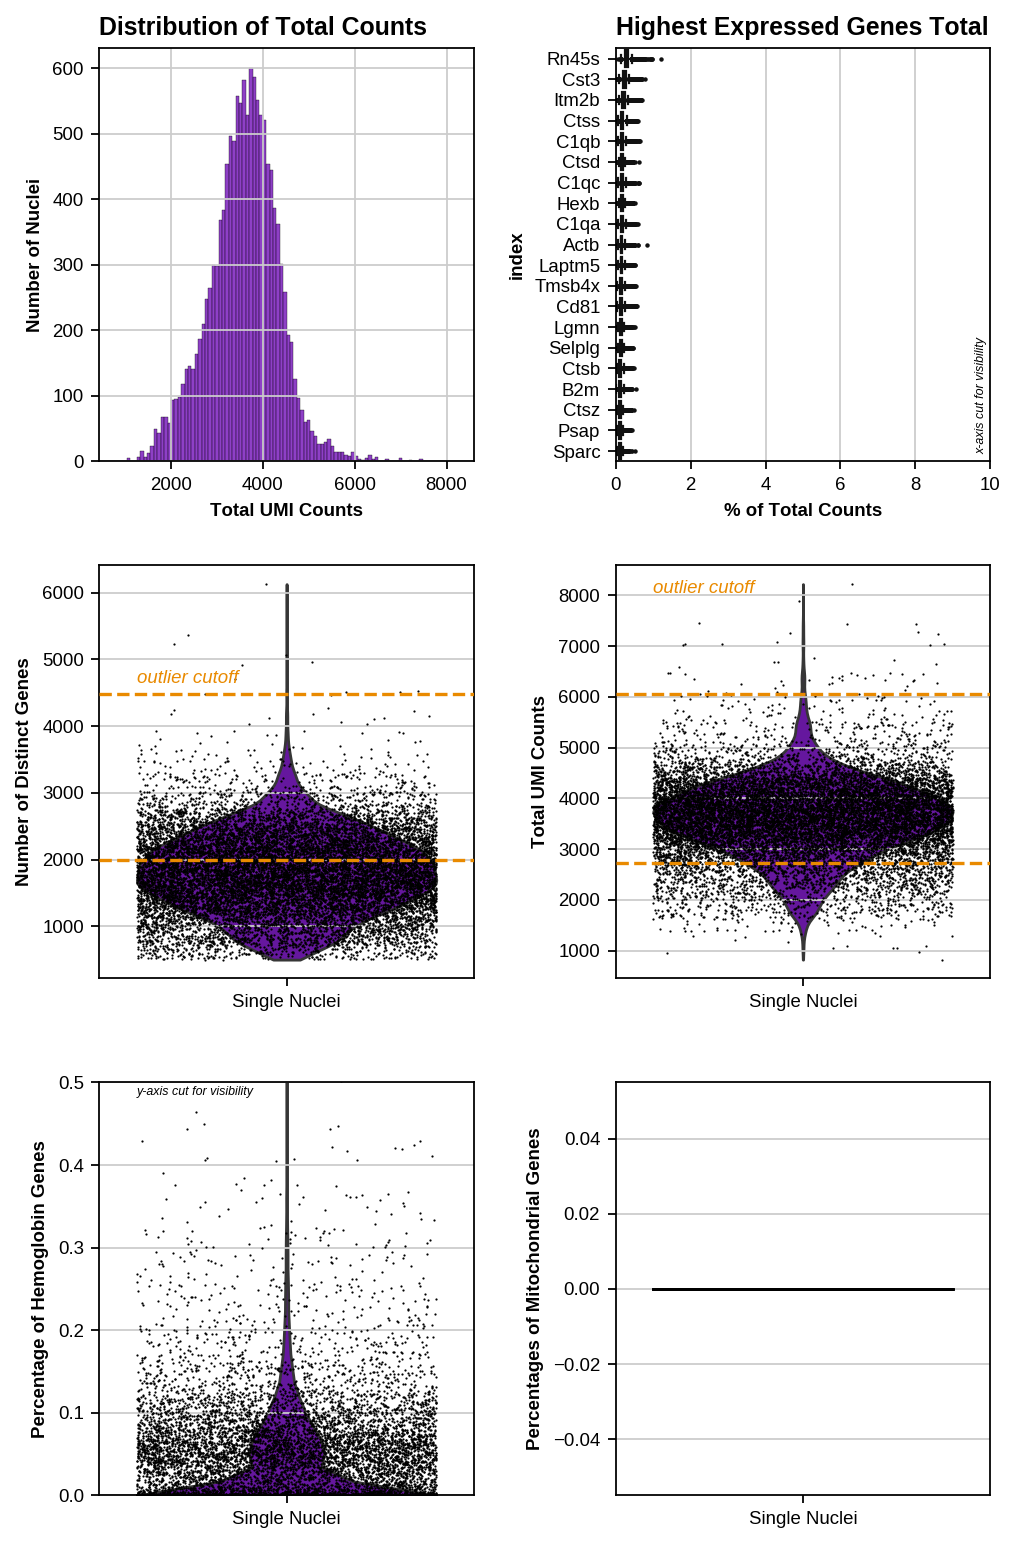

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(fig_width*2, fig_width*3), layout= "constrained")

sc.pl.violin(adata, ["n_genes_by_counts"], jitter= 0.4, ax= axes[1, 0], show= False, palette = my_cmap.colors)
axes[1, 0].set_xticklabels(["Single Nuclei"])
axes[1, 0].set_ylabel("Number of Distinct Genes")
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].text(-0.4, adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max()+170, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["total_counts"], jitter= 0.4, ax= axes[1, 1], show= False, palette = my_cmap.colors)
axes[1, 1].set_xticklabels(["Single Nuclei"])
axes[1, 1].set_ylabel("Total UMI Counts")
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].text(-0.4, adata[~adata.obs["outlier"]].obs["total_counts"].max()+2000, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["pct_counts_hb"], jitter= 0.4, ax= axes[2, 0], show= False, palette = my_cmap.colors)
axes[2, 0].set_xticklabels(["Single Nuclei"])
axes[2, 0].set_ylabel("Percentage of Hemoglobin Genes")
axes[2, 0].set_ylim(0, 0.5)
axes[2, 0].text(-0.4, 0.485, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["pct_counts_mt"], jitter= 0.4, ax= axes[2, 1], show= False, palette = my_cmap.colors)
axes[2, 1].set_xticklabels(["Single Nuclei"])
axes[2, 1].set_ylabel("Percentages of Mitochondrial Genes")

sc.pl.highest_expr_genes(adata, n_top=20, ax= axes[0, 1], show= False, palette= my_cmap.colors)
axes[0, 1].set_title("Highest Expressed Genes Total")
axes[0, 1].set_xlim(0, 10)
axes[0, 1].set_xlabel(r"% of Total Counts")
axes[0, 1].text(9.6, 19, "x-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                rotation= 90,
                fontstyle= "italic")

sns.histplot(adata.obs["total_counts"], bins = 100, kde= False, ax= axes[0, 0], color= my_cmap.colors[0])
axes[0, 0].set_title("Distribution of Total Counts")
axes[0, 0].set_xlabel("Total UMI Counts")
axes[0, 0].set_ylabel("Number of Nuclei")

fig.tight_layout(h_pad= 1.0*scale)
fig.savefig(figures_folder + r"\QC_metrics_Tabula_Muris.png")
plt.show()

In [22]:
adata.obs["total_counts"].median()

3630.2104

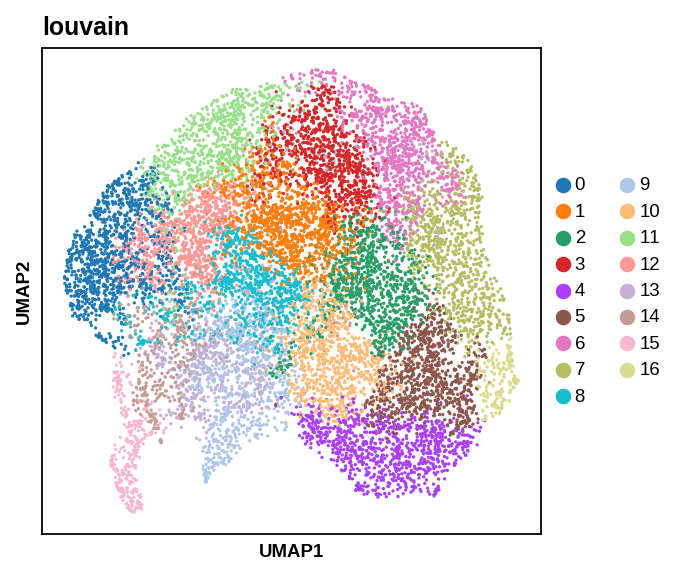

In [18]:
sc.pl.umap(adata, color= "louvain")